In [1]:
#import packages
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as sps
import scipy.optimize as spop
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


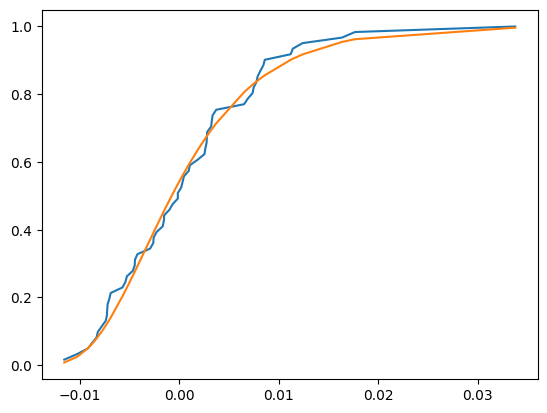

The p-value of the Kolmorogov-Smirnov test equals 72.3608%
The distribution fits the data


In [2]:
#Johnson SU distribution
#probability density function: f(x) = scale2/(scale1*sqrt(2*pi))/sqrt(1+((x-loc1)/scale1)^2)*e^(-1/2*(loc2 + scale2*arcsinh((x-loc1)/scale1))^2)
#cumulative distribution function: F(x) = N(loc2 + scale2*arcsinh((x-loc1)/scale1))
#specify the sample
ticker = 'RSG'
start = '2023-04-29'
end = '2023-07-29'
#retrieve data
prices = yf.download(ticker, start, end)['Close']
#calculate and sort returns
returns = np.array(prices[1:])/np.array(prices[:-1]) - 1
returns = np.sort(returns)
#construct empirical distribution function
edf = np.arange(1, len(returns)+1)/len(returns)
#calculate mean and standard deviation
mean = np.average(returns)
std = np.std(returns)
#optimise Johnson SU distribution parameters using maximum likelihood estimation
def johnson_su_optimisation(k):
    k[1] = abs(k[1])
    k[3] = abs(k[3])
    pdf = k[3]/(k[1]*(2*np.pi)**(1/2))/(1 + ((returns - k[0])/k[1])**2)**(1/2)*np.exp(-1/2*(k[2] + k[3]*np.arcsinh((returns - k[0])/k[1]))**2)
    return -np.sum(np.log(pdf))
#retrieve optimal distribution parameters
res = spop.minimize(johnson_su_optimisation, [mean, std, 0, 1], method='Nelder-Mead')
su_loc_1 = res.x[0]
su_scale_1 = abs(res.x[1])
su_loc_2 = res.x[2]
su_scale_2 = abs(res.x[3])
#calculate the cumulative distribution function
cdf = sps.norm.cdf(su_loc_2 + su_scale_2*np.arcsinh((returns - su_loc_1)/su_scale_1))
#visualise the distribution functions
plt.plot(returns, edf)
plt.plot(returns, cdf)
plt.show()
#evaluate the goodness-of-fit using Kolmogorov-Smirnov test
supremum = max(abs(edf - cdf))
p_value = np.exp(-supremum**2*len(returns))
print('The p-value of the Kolmorogov-Smirnov test equals '+str(round(p_value*100,4))+'%')
if p_value < 0.1:
    print('The distribution does not fit the data')
else:
    print('The distribution fits the data')

In [3]:
#retrieve the option book of the underlying
options = yf.Ticker(ticker).option_chain('2023-08-18')
calls = options.calls
puts = options.puts

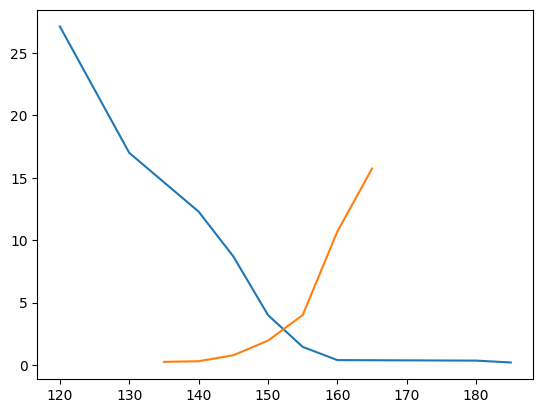

In [4]:
#visualise market option prices
plt.plot(calls['strike'], calls['lastPrice'])
plt.plot(puts['strike'], puts['lastPrice'])
plt.show()

In [5]:
#specify the dimension of the seed for valuation
maturity = 30
n_sim = 1000
seed = np.random.random((maturity, n_sim))

In [6]:
#generate returns using the seed and the Johnson SU quantile function
#returns = loc1 + scale1*sinh((F(random) - loc2)/scale2)
sim_returns = su_loc_1 + su_scale_1*np.sinh((sps.norm.ppf(seed) - su_loc_2)/su_scale_2)

In [7]:
#simulate prices and calculate relevant values for payoff calculation
sim_prices = prices[-1]*pd.DataFrame(1 + sim_returns).cumprod()
max_prices = sim_prices.max()
min_prices = sim_prices.min()
price_at_expiry = sim_prices.iloc[-1]

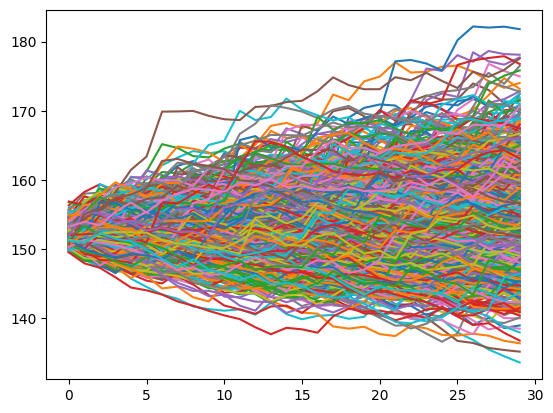

In [8]:
#visualise price random walks
plt.plot(sim_prices)

In [9]:
#specify the option characteristics
strike = 150
barrier_up = 160
barrier_down = 135
risk_free = 0.0537  # Rsik free rate = 5.37%

In [10]:
#calculate option payoffs and values
up_in_payoff = (max_prices >= barrier_up)*np.maximum(0, price_at_expiry - strike)
up_out_payoff = (max_prices < barrier_up)*np.maximum(0, price_at_expiry - strike)
down_in_payoff = (min_prices <= barrier_down)*np.maximum(0, strike - price_at_expiry)
down_out_payoff = (min_prices > barrier_down)*np.maximum(0, strike - price_at_expiry)
up_in_value = np.average(up_in_payoff)/(1 + risk_free)**(maturity/252)
up_out_value = np.average(up_out_payoff)/(1 + risk_free)**(maturity/252)
down_in_value = np.average(down_in_payoff)/(1 + risk_free)**(maturity/252)
down_out_value = np.average(down_out_payoff)/(1 + risk_free)**(maturity/252)
print('the fair value of the up-and-in call at strike '+str(strike)+' and barrier '+str(barrier_up)+' equals '+str(round(up_in_value,2))+'.')
print('the fair value of the up-and-out call at strike '+str(strike)+' and barrier '+str(barrier_up)+' equals '+str(round(up_out_value,2))+'.')
print('the fair value of the down-and-in put at strike '+str(strike)+' and barrier '+str(barrier_down)+' equals '+str(round(down_in_value,2))+'.')
print('the fair value of the down-and-out put at strike '+str(strike)+' and barrier '+str(barrier_down)+' equals '+str(round(down_out_value,2))+'.')
call_value = up_in_value + up_out_value
put_value = down_in_value + down_out_value
call_price = float(calls[calls['strike'] == strike]['lastPrice'])
put_price = float(puts[puts['strike'] == strike]['lastPrice'])


the fair value of the up-and-in call at strike 150 and barrier 160 equals 4.05.
the fair value of the up-and-out call at strike 150 and barrier 160 equals 1.81.
the fair value of the down-and-in put at strike 150 and barrier 135 equals 0.02.
the fair value of the down-and-out put at strike 150 and barrier 135 equals 0.91.


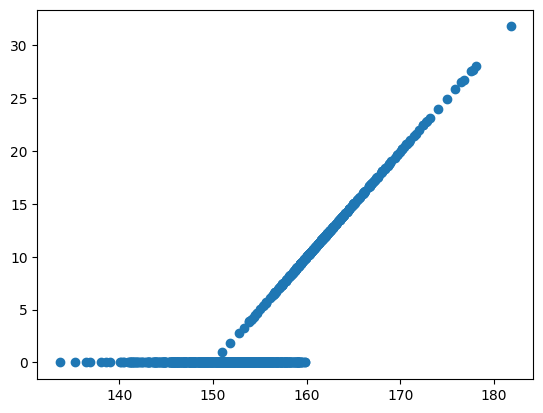

In [11]:
plt.scatter(price_at_expiry,up_in_payoff)

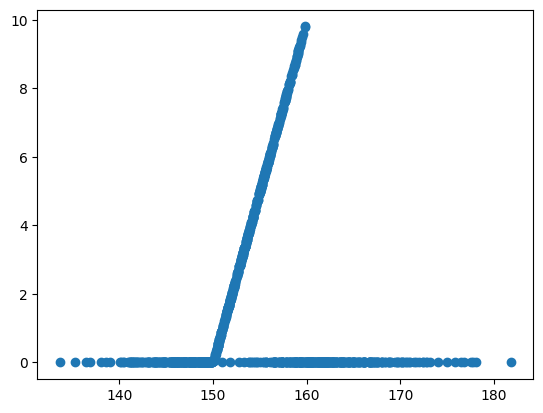

In [12]:
plt.scatter(price_at_expiry,up_out_payoff)

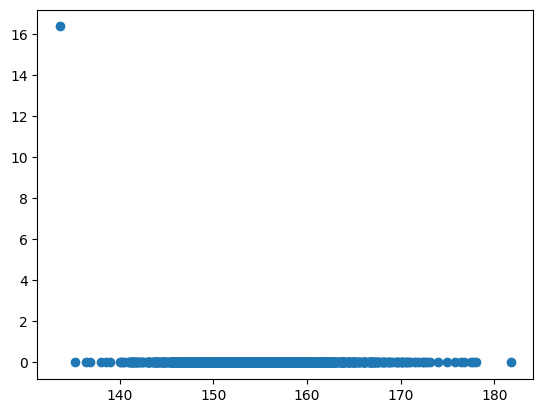

In [13]:
plt.scatter(price_at_expiry,down_in_payoff)

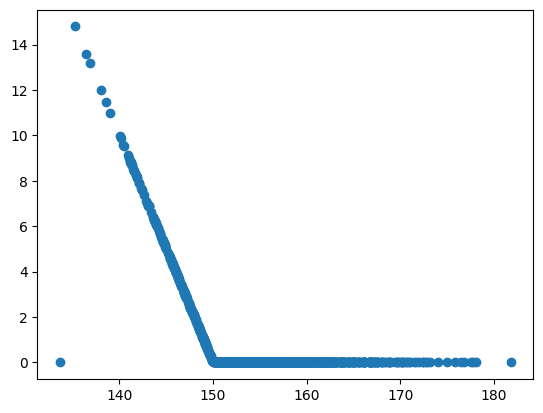

In [14]:
plt.scatter(price_at_expiry,down_out_payoff)

In [15]:
print('the fair value of the call at strike '+str(strike)+' equals '+str(round(call_value,2))+'.')
if call_value > call_price:
    print('the call option available at the market is undervalued at '+str(call_price)+'.')
else:
    print('the call option available at the market is overvalued at '+str(call_price)+'.')
    
print('the fair value of the put at strike '+str(strike)+' equals '+str(round(put_value,2))+'.')
if put_value > put_price:
    print('the put option available at the market is undervalued at '+str(put_price)+'.')
else:
    print('the put option available at the market is overvalued at '+str(put_price)+'.')    

the fair value of the call at strike 150 equals 5.86.
the call option available at the market is undervalued at 4.0.
the fair value of the put at strike 150 equals 0.92.
the put option available at the market is overvalued at 1.95.


In [16]:
###################################### THE END ###############################################################